# Ячейка 1: Импорт библиотек и загрузка данных

In [243]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Для моделирования
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.decomposition import PCA
from matplotlib.colors import ListedColormap

# Указываем имя файла для загрузки
file_path = 'cat_dog_noisy_300.csv'

# Загружаем данные из CSV-файла в DataFrame
try:
    df = pd.read_csv(file_path)
    print(f"Файл '{file_path}' успешно загружен.")
except FileNotFoundError:
    print(f"Ошибка: Файл '{file_path}' не найден. Убедитесь, что он находится в той же папке, что и ваш Notebook.")
    # В случае ошибки, создаем пустой DataFrame, чтобы избежать дальнейших сбоев
    df = pd.DataFrame()

if not df.empty:
    # Посмотрим на первые 5 строк, чтобы убедиться, что все загрузилось правильно
    print("\nПервые 5 строк данных:")
    print(df.head())

    print("\nИнформация о данных:")
    df.info()

Файл 'cat_dog_noisy_300.csv' успешно загружен.

Первые 5 строк данных:
   active_sport  hours_outside  likes_active_leisure  likes_passive_leisure  \
0             1              7                     1                      0   
1             1              8                     1                      1   
2             0             10                     0                      1   
3             1              5                     1                      0   
4             0             11                     0                      1   

   travels_often  is_extrovert  is_introvert  lives_in_house  \
0              0             1             0               1   
1              0             1             0               1   
2              1             0             1               0   
3              0             1             0               1   
4              1             0             1               0   

   lives_in_apartment  park_nearby  has_children  wants_to_love  \
0 

# Ячейка 2: Подготовка данных для модели

In [244]:
# 1. Отделяем признаки (X) и целевую переменную (y)
X = df.drop('pet_preference', axis=1)
y_raw = df['pet_preference']

# 2. Преобразуем текстовые метки в числовые (cat -> 0, dog -> 1)
y = y_raw.map({'cat': 0, 'dog': 1})

# 3. Разделяем данные на обучающую и тестовую выборки (80% на обучение, 20% на тест)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 4. Масштабируем признаки
# Это очень важный шаг для алгоритмов, основанных на расстоянии, таких как k-NN
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Размер обучающей выборки: {X_train_scaled.shape}")
print(f"Размер тестовой выборки: {X_test_scaled.shape}")

Размер обучающей выборки: (348, 16)
Размер тестовой выборки: (87, 16)


# Ячейка 3: Оценка базовой модели (k=5)

Эта ячейка полезна, чтобы видеть результат для одного конкретного k перед тем, как мы начнем поиск лучшего.

Точность (Accuracy) модели: 0.97

Отчет по классификации:
              precision    recall  f1-score   support

   Cat Lover       0.97      0.95      0.96        41
   Dog Lover       0.96      0.98      0.97        46

    accuracy                           0.97        87
   macro avg       0.97      0.96      0.97        87
weighted avg       0.97      0.97      0.97        87


Матрица ошибок:


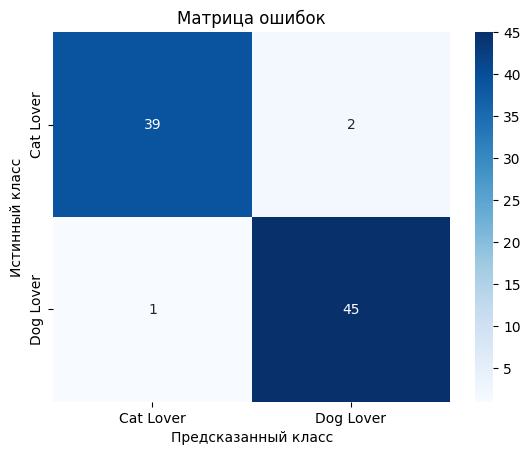

In [245]:
# Создаем экземпляр классификатора с k=5
# Смена k Ближайших соседей
knn = KNeighborsClassifier(n_neighbors=5)

# Обучаем модель на масштабированных обучающих данных
knn.fit(X_train_scaled, y_train)

# Делаем предсказания на тестовых данных
y_pred = knn.predict(X_test_scaled)

# Оцениваем качество модели
accuracy = accuracy_score(y_test, y_pred)
print(f"Точность (Accuracy) модели: {accuracy:.2f}")

print("\nОтчет по классификации:")
print(classification_report(y_test, y_pred, target_names=['Cat Lover', 'Dog Lover']))

print("\nМатрица ошибок:")
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Cat Lover', 'Dog Lover'], yticklabels=['Cat Lover', 'Dog Lover'])
plt.xlabel('Предсказанный класс')
plt.ylabel('Истинный класс')
plt.title('Матрица ошибок')
plt.show()

# Ячейка 4: Поиск оптимального значения k
Это новая, самая важная ячейка. Она автоматизирует поиск лучшего k.

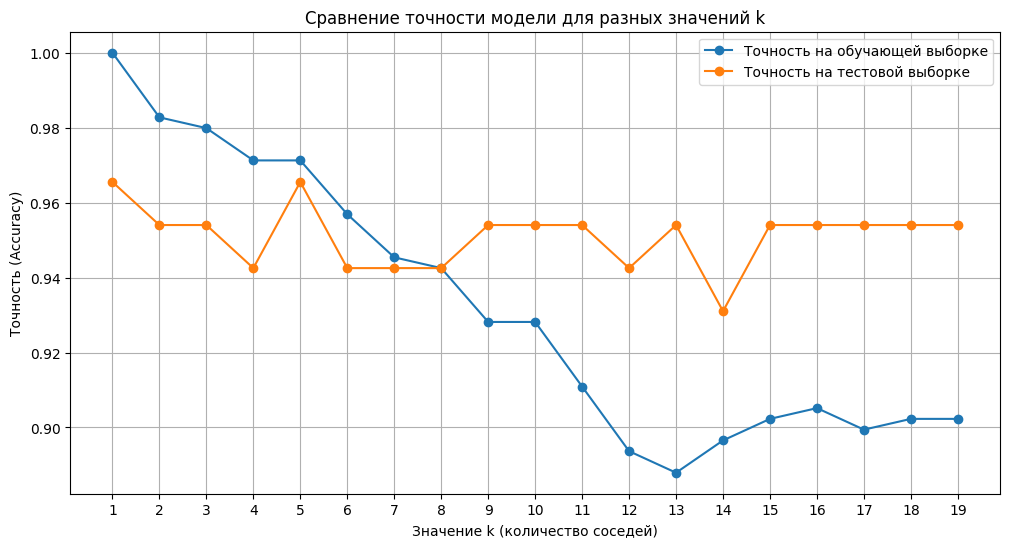

[0.9655172413793104, 0.9540229885057471, 0.9540229885057471, 0.9425287356321839, 0.9655172413793104, 0.9425287356321839, 0.9425287356321839, 0.9425287356321839, 0.9540229885057471, 0.9540229885057471, 0.9540229885057471, 0.9425287356321839, 0.9540229885057471, 0.9310344827586207, 0.9540229885057471, 0.9540229885057471, 0.9540229885057471, 0.9540229885057471, 0.9540229885057471]

Анализ завершен.
Наилучшее значение k найдено: 1
Максимальная точность на тестовой выборке: 0.97


In [246]:
# Задаем диапазон значений k для проверки
# Будем использовать только нечетные значения, чтобы избежать ничьей при голосовании
k_range = range(1, 20, 1)

# Создаем списки для хранения точности на обучающей и тестовой выборках
train_scores = []
test_scores = []

# Проходим в цикле по всем значениям k
for k in k_range:
    # Создаем и обучаем модель
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)
    
    # Считаем точность на обучающей выборке и добавляем в список
    train_scores.append(knn.score(X_train_scaled, y_train))
    
    # Считаем точность на тестовой выборке и добавляем в список
    test_scores.append(knn.score(X_test_scaled, y_test))

# Строим график
plt.figure(figsize=(12, 6))
plt.plot(k_range, train_scores, marker='o', label='Точность на обучающей выборке')
plt.plot(k_range, test_scores, marker='o', label='Точность на тестовой выборке')
plt.xlabel('Значение k (количество соседей)')
plt.ylabel('Точность (Accuracy)')
plt.title('Сравнение точности модели для разных значений k')
plt.legend()
plt.xticks(k_range)
plt.grid(True)
plt.show()

# Находим и выводим лучшее значение k
best_k = k_range[np.argmax(test_scores)]
best_accuracy = max(test_scores)
print(test_scores)
print(f"\nАнализ завершен.")
print(f"Наилучшее значение k найдено: {best_k}")
print(f"Максимальная точность на тестовой выборке: {best_accuracy:.2f}")

# Ячейка 5: Визуализация с наилучшим значением k
Теперь мы используем best_k, найденное в предыдущей ячейке, для финальной визуализации.

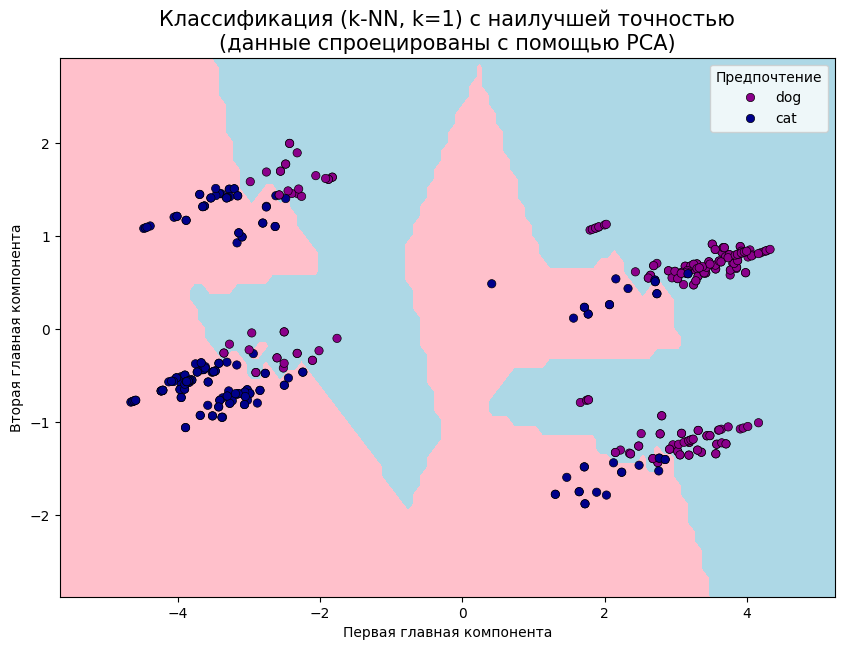

In [247]:
# Снижаем размерность всех данных до 2 компонент для визуализации
pca = PCA(n_components=2)
X_pca = pca.fit_transform(scaler.transform(X)) # Масштабируем все данные перед PCA

# Обучаем новую модель k-NN на 2D-данных, используя НАЙДЕННОЕ ЛУЧШЕЕ ЗНАЧЕНИЕ k
knn_2d = KNeighborsClassifier(n_neighbors=best_k)
knn_2d.fit(X_pca, y)

# Создаем сетку для построения графика
x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

# Предсказываем класс для каждой точки на сетке
Z = knn_2d.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Цвета для графика
cmap_light = ListedColormap(['#FFC0CB', '#ADD8E6'])
cmap_bold = ['darkmagenta', 'darkblue']

# Рисуем график
plt.figure(figsize=(10, 7))
plt.contourf(xx, yy, Z, cmap=cmap_light)
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y_raw,
                palette=cmap_bold, alpha=1.0, edgecolor="black")
plt.title(f"Классификация (k-NN, k={best_k}) с наилучшей точностью\n(данные спроецированы с помощью PCA)", fontsize=15)
plt.xlabel("Первая главная компонента")
plt.ylabel("Вторая главная компонента")
plt.legend(title="Предпочтение")
plt.show()